<a href="https://www.kaggle.com/code/christianlippai/store-sales-forecasting-a-guide-to-ml?scriptVersionId=176511790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><img src="https://media.blogto.com/articles/20211209-empress-walk-escalator-2.jpg?w=2048&cmd=resize_then_crop&height=1365&quality=70" style="width:100%;height:50%;"></center>

# Table of Contents

* [Introduction](#chapter1)
    * [This Series of Blogs](#this-series-of-blogs)
* [Data Overview](#chapter2)
* [Exploratory Data Analysis (EDA)](#chapter3)
    * [Plots Have Patterns](#plots-have-patterns)
    * [Heat Maps and Distribution of Sales](#heat-maps-and-distribution-of-sales)
* [Linear Regression](#chapter4)
    * [Adding Features to Capture Patterns](#adding-features-to-capture-patterns)
    * [Training Our Model](#training-our-model)
    * [Visualizing and Testing Our Model](#visualizing-and-testing-our-model)
* [Conclusions](#chapter5)

## Introduction  <a class="anchor"  id="chapter1"></a>

<span style="font-size: 14pt; font-family: 'Circular';">
  
(phrasing as though its a medium blog post) 
    
The goal of this is blog is two fold; firstly we want to understand how machine learning can be used to study real world data such as store sales. At the end of the day by “study” we often mean, develop a model for predicting future sales.This is called a quantitative model for time series data, and can be powered by machine learning models. Grocery stores want to avoid overpredicting future sales as this can lead to food waste. Underpredicting future sales however can lead to goods selling out, and unhappy customers. Quantitative models help us predict the future to avoid these situations, and in this blog post I give an example of how this can be done using Python.
    
Secondly, we want to use this large store sales data set as a way to study machine learning algorithms and data science techniques. In this blog we focus on how data visualization can aid in feature engineering, and the pros and cons of using a linear regression model. 
    
We try to make each section as accessible to a beginner as can be done concisely, however a familiarity with some of the basics of Python and Pandas is expected. https://www.youtube.com/playlist?list=PL-osiE80TeTsWmV9i9c58mdDCSskIFdDS is a concise introduction.

### <span id="this-series-of-blogs" style="color:#696969;font-size: 17pt;">This Series of Blogs</span>
    
In future blog posts I plan to discuss other topics related to store sales forecasting such as data transformations, the importance of using fast vectorized operations, autocorrelation analysis, hybrid models, data pipelines, and hyperparameter tuning. 
    
Overall by the end of reading this series of blog posts if there is one thing I’d like to get across its that in the context of machine learning and quantitative modeling; obstacles that appear to be set in stone are often sermountable when one introduces the necessary creative fixes.

## Data Overview <a class="anchor"  id="chapter2"></a>

<span style="font-size: 14pt; font-family: 'Circular';">
    
This project was inspired by the Kaggle competition https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview, where we are tasked to find the best way to forecast store sales from the store chain Corporación Favorita located in Ecuador. In this competition we are given different data files some of which describe sales data for Favorita stores, and others which describe contributing factors such as Ecuadorian holidays. 
  
In this blog we work mainly with the train.csv file, and we load in this data below.

In [2]:
from pathlib import Path
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# load in training data
comp_dir = Path('../input/store-sales-time-series-forecasting')
train_data = pd.read_csv(comp_dir / 'train.csv')

train_data['date'] = pd.to_datetime(train_data['date'])
pd.set_option('display.max_rows', 10)
display(train_data)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


<span style="font-size: 14pt; font-family: 'Circular';">

This data frame contains sales data over a variety of stores and product families. The sales column represents the number of sales from the store labeled by store_nbr in the product family described by family, on a specific date. The triplet (family, store number, date) uniquely defines each row, in otherwords no triplet occurs more than once. If a specific store is not selling any items from a product family, then zeros are included in the sales column.
    

## Exploratory Data Analysis (EDA)  <a class="anchor"  id="chapter3"></a>

<span style="font-size: 14pt; font-family: 'Circular';">

In this section we explore the above data using a variety of visualization techniques involving matplotlib and seaborn. It's often through visuals that we can figure out which factors (e.g day of the weak) are the best predictors of our target variable, sales. This is key as we can then use these factors to create new columns in our training set (these are called features), which make training a machine learning model possible.
    
Companies use data visualization to detect large scale trends in their sales, and to spot the effect of unexpected behaviour caused by special events like the Earthquake which hit Ecuador on April 16 2016. Data visualization is also key in many areas of business; stakeholders and investors of a company need a clear overview of the company's activity and customer traffic over time.

### <span id = "plots-have-patterns" style="color:#696969;font-size: 17pt;">Plots Have Patterns</span>

<span style="font-size: 14pt; font-family: 'Circular';">

 Given a specified product family, and a specified store number we can isolate our focus to the time series which pertains to that specific store and product family. train.csv contains 33 product family's and 54 stores, and thus can be viewed as being constructed from a total of 33*54 = 1782 different time series. These time series are the building blocks of this data set.

Below we create a function cross_section which retreives one of these blocks from the data. First we index train_data to have three index's based off of the values in the three columns "family", "store_number", "date". We do this since as mentioned before, each triplet of values in the columns 'store_nbr', 'family', 'date', uniquely define a row. 
    

In [3]:
train_data = train_data.set_index(['store_nbr', 'family', 'date']).sort_index()

# Returns the data associated with a specific store and product family from the dataframe df. 
def cross_section(df, store_nbr,family):
    specific_store_data = df.xs(key=(store_nbr, family), level=('store_nbr', 'family'))
    return(specific_store_data)


<span style="font-size: 14pt; font-family: 'Circular';">

Now we can extract the deli data from store 3 and display our results.

In [4]:
store3_deli = cross_section(train_data, 3, "DELI")

display(store3_deli)

,id,sales,onpromotion
date,,,
2013-01-01,735,0.000,0
2013-01-02,2517,600.273,0
2013-01-03,4299,421.195,0
2013-01-04,6081,347.192,0
2013-01-05,7863,594.503,0
...,...,...,...
2017-08-11,2992713,416.172,67
2017-08-12,2994495,355.900,8
2017-08-13,2996277,395.272,8


<span style="font-size: 14pt; font-family: 'Circular';">

The best way to start our EDA off is to simply graph the different building blocks of our data set over time. We define a function which uses seaborn and matplotlib to help us visualize time series data. 

In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
    
def my_plot(title, s, my_color,line_width):
    # Set the style
    sns.set_style("whitegrid")
    
    # Create the plot
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=s, color=my_color, linewidth=line_width, linestyle='-')
    
    # Customize labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.title(title, fontsize=14)
    
    # Customize tick labels
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)
    
    # Set the major locator for x-axis ticks every year
    plt.gca().xaxis.set_major_locator(YearLocator())
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Now we can use this function to generate a plot for the store 3 deli sales data. 

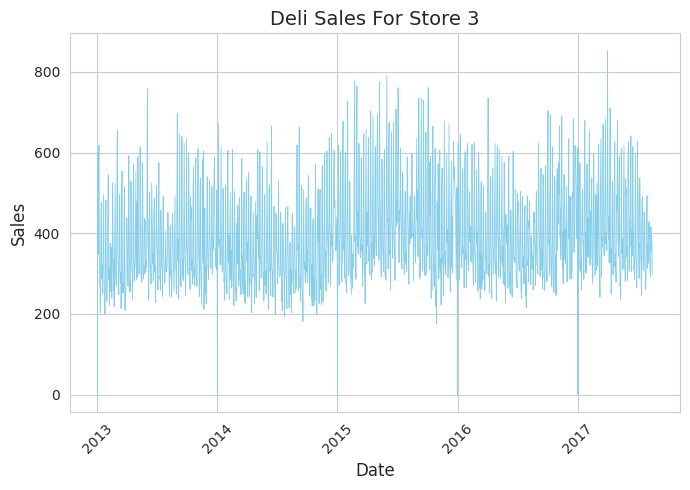

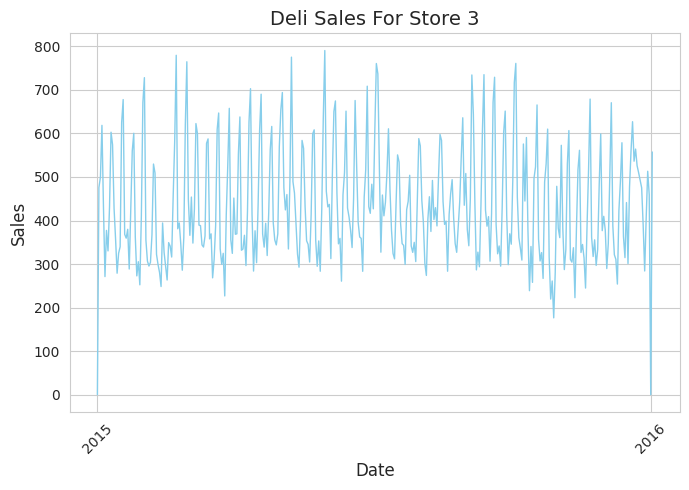

In [6]:
store3_deli_sales = store3_deli["sales"]

my_plot('Deli Sales For Store 3',store3_deli_sales,'skyblue',0.6)
my_plot('Deli Sales For Store 3',store3_deli_sales['2015-01-01':'2016-01-02'], 'skyblue',1)

<span style="font-size: 14pt; font-family: 'Circular';">

We want to gain a better understanding of the structure of this time series, and so we can plot rolling averages. Rolling averages calculate the mean of the previous n sales values and plot that value at each point in time. So a 28 day rolling average computes the mean of the last four weeks of sales. 28 day rolling averages are useful when capturing seasonal patterns in the data, however 365 day rolling averages are useful for capturing long scale trends. 
   

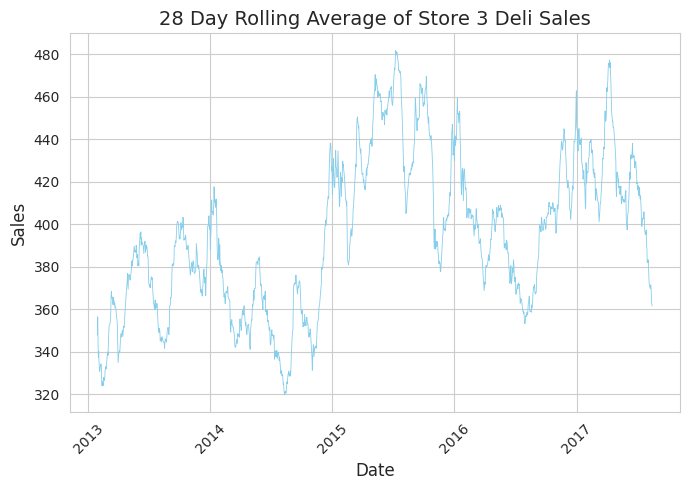

In [7]:
##### Calculate the 28-day rolling average
rolling_avg = store3_deli_sales.rolling(window=28).mean()
my_plot('28 Day Rolling Average of Store 3 Deli Sales',rolling_avg, 'skyblue',0.6)

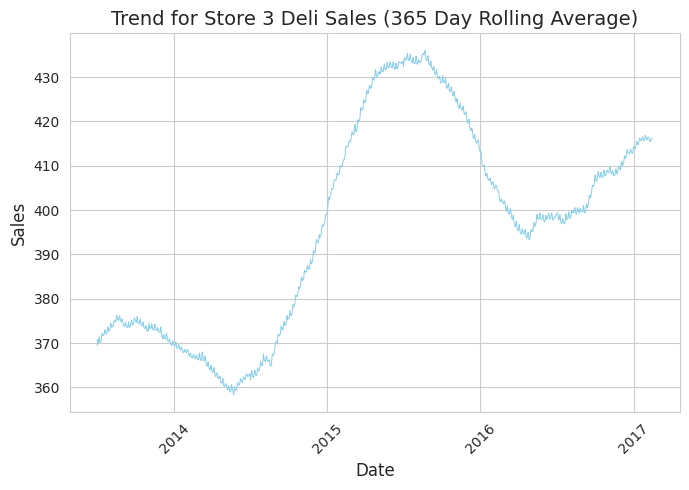

In [8]:
trend = store3_deli_sales.rolling(window= 365, center = True).mean()
my_plot('Trend for Store 3 Deli Sales (365 Day Rolling Average)', trend, "skyblue",0.7)

<span style="font-size: 14pt; font-family: 'Circular';">

We would like to efficiently display all of the plots above for a variety of product family/store number pairs. To do this we create a summary function. Favorita stores are grouped into the same "type" if they share enough similarities, and this information is included in the stores.csv file retreived from Kaggle. In the summary function we color the resulting plot based on the type of the store.

In [9]:
stores = pd.read_csv(comp_dir / 'stores.csv')

# returns the type of the Favorita store defined by store_nbr
def to_store_type(store_nbr):
    store_type = stores["type"].iloc[store_nbr-1]
    return(store_type)

# chooses the color to plot based on the store type.     
def to_color(store_type):
    if store_type == "A":
        return('green')
    if store_type == "B":
        return('purple')
    if store_type == "C":
        return('orange')
    if store_type == "D":
        return('skyblue')
    if store_type == "E":
        return('brown')

# plots a variety of rolling averages for the data pertaining to store_nbr and family. 
def summary(df, store_nbr, family):
    store_color = to_color(to_store_type(store_nbr))
    
    specific_store_product_sales = cross_section(train_data, store_nbr, family)['sales']
    my_plot(f'{family} Sales For Store {store_nbr}',specific_store_product_sales, store_color,0.5)
    my_plot(f'{family} Sales For Store {store_nbr} Zoomed',specific_store_product_sales['2015-01-01':'2016-01-02'], store_color,1)
    
    # Calculate the 28-day rolling average
    rolling_avg = specific_store_product_sales.rolling(window=28).mean()
    my_plot(f'28 Day Rolling Average of Store {store_nbr} {family} Sales',rolling_avg, store_color,0.6)
    
    trend = specific_store_product_sales.rolling(window= 365, center = True).mean()
    my_plot(f'Trend for Store {store_nbr} {family} Sales (365 Day Rolling Averge)', trend, store_color,0.7)

<span style="font-size: 14pt; font-family: 'Circular';">

Now lets test out our function by printing the summary of store 28's Grocery 1 sales. 
    

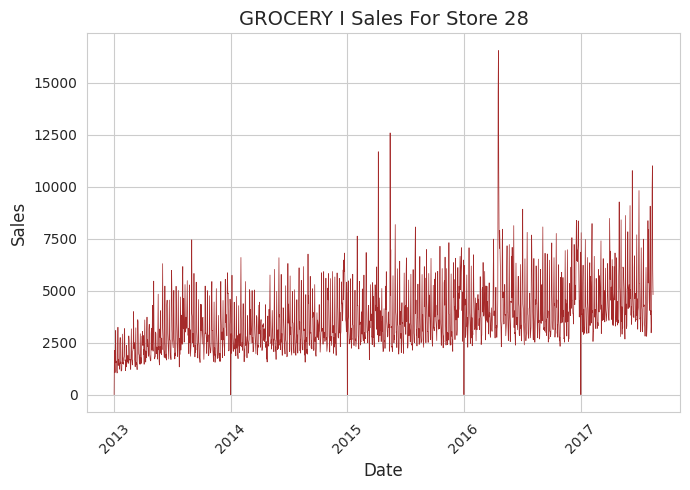

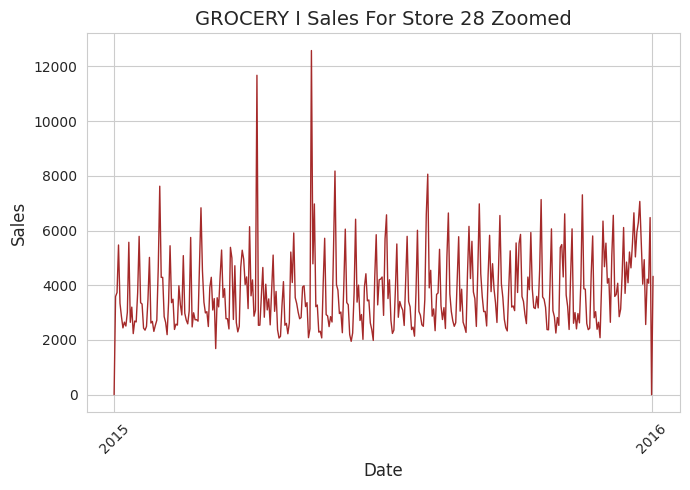

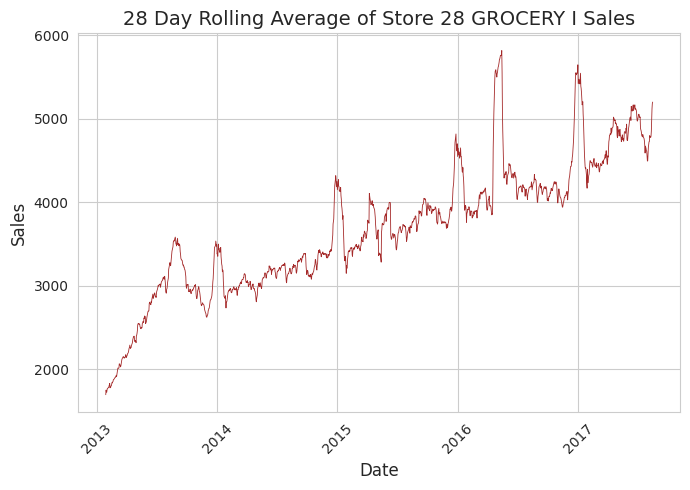

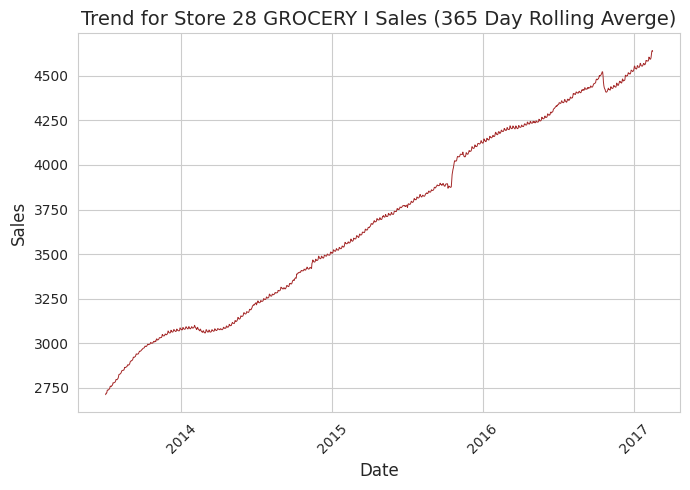

In [10]:
summary(train_data, 28,"GROCERY I")

<span style="font-size: 14pt; font-family: 'Circular';">

By tracing the up and down motion carefully in the second plot (the zoomed plot) one can see a pattern that typically repeats on a weekly basis. This suggests that the day of the week is a powerful predictor of store sales, and thus when training our machine learning model we should add the day of the week as a feature (column) to the training/test sets. 

The third plot (28-day rolling average) accentuates seasonal patterns.This pattern seems more complex and variable than the weekly pattern. However there is a clear spike in the month of December. We will include "the month of the year" as a feature in our training/test data, as we expect many products to be heavily dependent on the season. 

One example of strong seasonality can be seen in the Frozen Foods product family summarized below: 


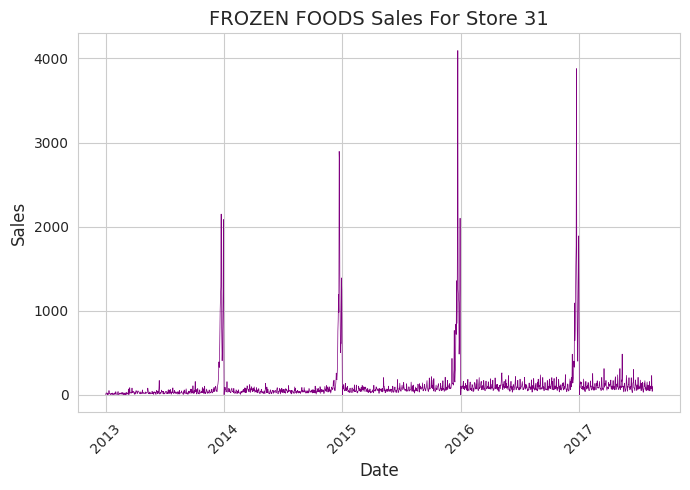

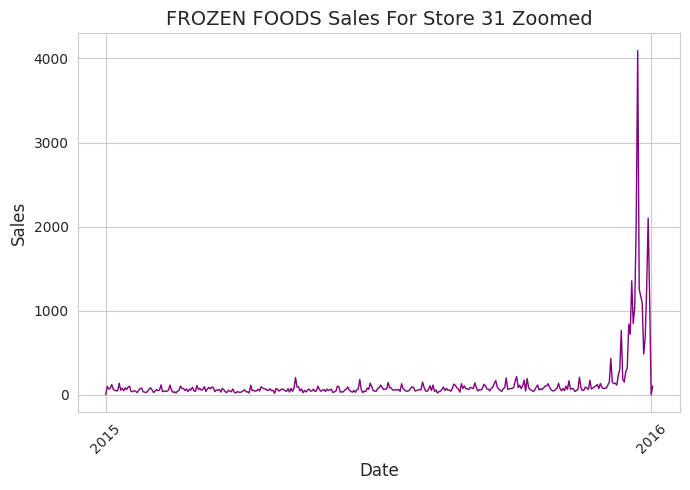

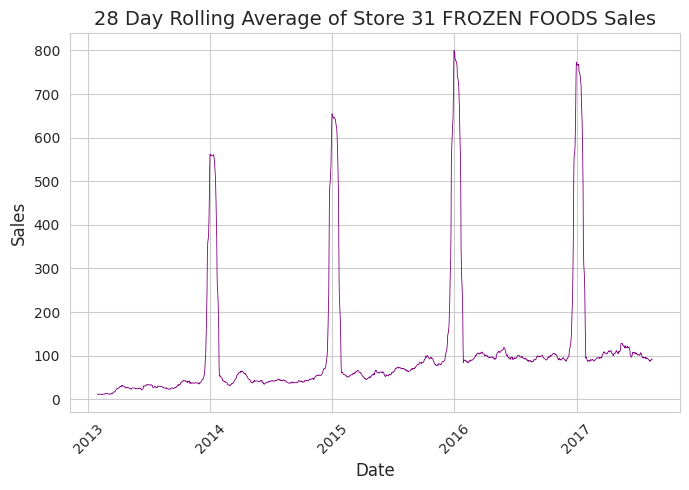

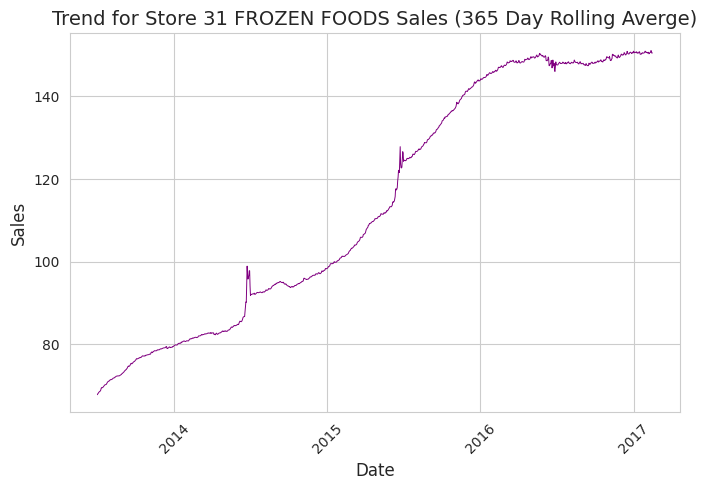

In [11]:
summary(train_data, 31, "FROZEN FOODS")

<span style="font-size: 14pt; font-family: 'Circular';">

Veiwing the 28 day rolling average we see a consistent massive spike that occurs during December. It is understandable that a spike like this exists since frozen meats such as turkeys are very popular during Christmas time. However the spike seems larger than one would expect. Perhaps this particular store is well known for having promotional deals during Christmas time? In the train data set we have a record of the number of items which are "onpromotion", and we will include this as a feature in our first model.

Viewing the final graph for this product family, we can clearly see a consistent trend for frozen food sales. There is an upward trend which appears to be fairly linear. Therefore we will add a feature which encodes for the time that has passed in days since 2013, and this will help our model extrapolate the linear trend. 

This data has a relatively predictable trend and seasonal pattern, and so it could be clasified as structured data. Some product family's are more caotic however, and ML models will have a more difficult time forecasting into the future for these models. Note the home appliances family for store number 20 below:
   

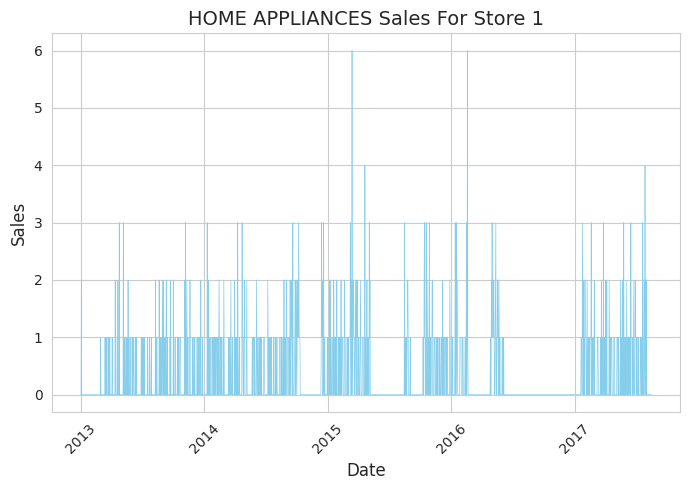

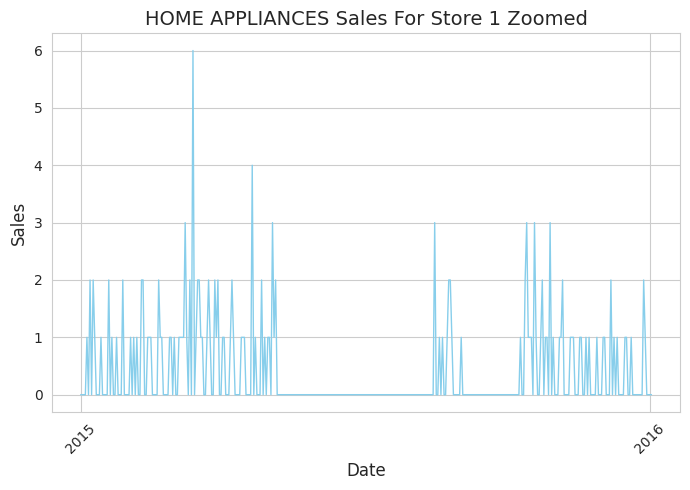

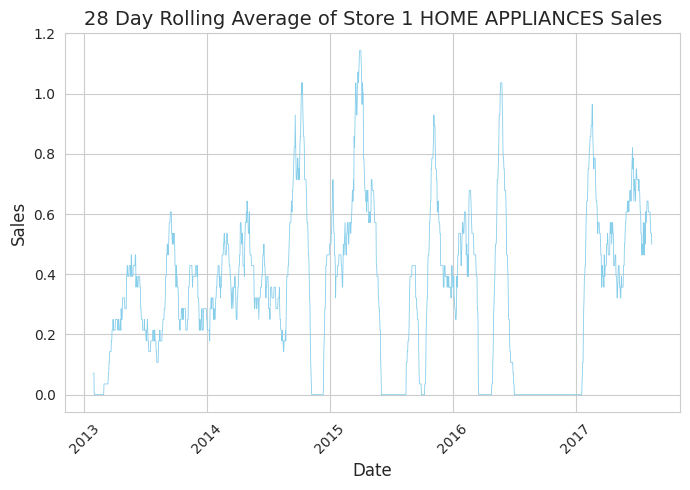

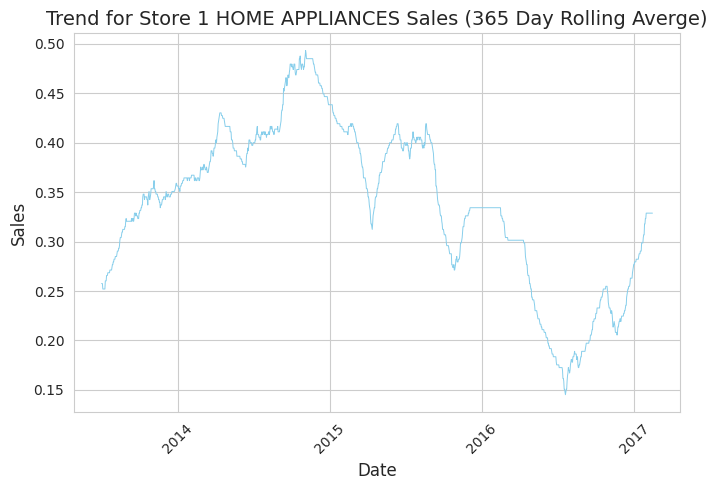

In [12]:
summary(train_data, 1, "HOME APPLIANCES")

<span style="font-size: 14pt; font-family: 'Circular';">

The Appliance data appears much more random than the other product families. That being said ML algorithms often find patterns which are not clear at first glance.  
    
### <span id = "heat-maps-and-distribution-of-sales" style="color:#696969;font-size: 17pt;">Heat Maps and Distribution of Sales</span>


Based on the above plots some product families and stores have much more sales than others. To investigate this further we produce two heatmaps. The first one plots the mean number of sales per day for each (family, store_nbr) pair. The second heat map plots the relative precentage of sales from the store identified by store_nbr that come from each family.
  

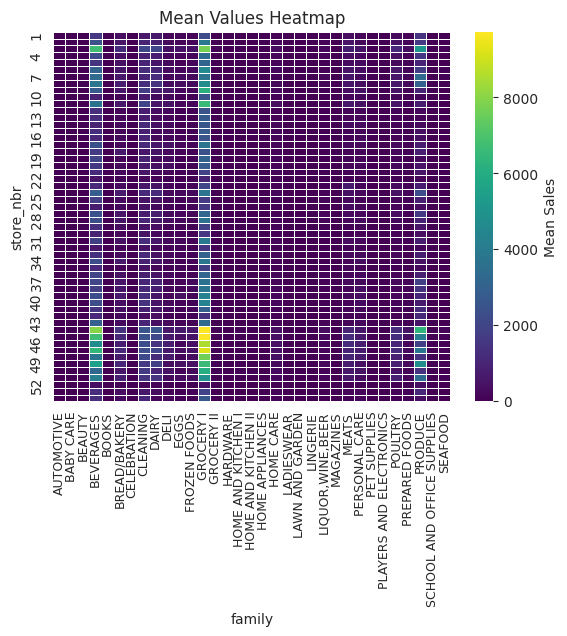

In [13]:
# Group by and calculate mean
grouped_mean = train_data.groupby(['store_nbr', 'family']).mean()

# Pivot the table
heatmap_data = grouped_mean.pivot_table(index='store_nbr', columns='family', values='sales')

# Create a heatmap using seaborn
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", linewidths=.5, xticklabels=True, cbar_kws={'label': 'Mean Sales'})
plt.title('Mean Values Heatmap')
plt.xticks(fontsize=9)
plt.show()

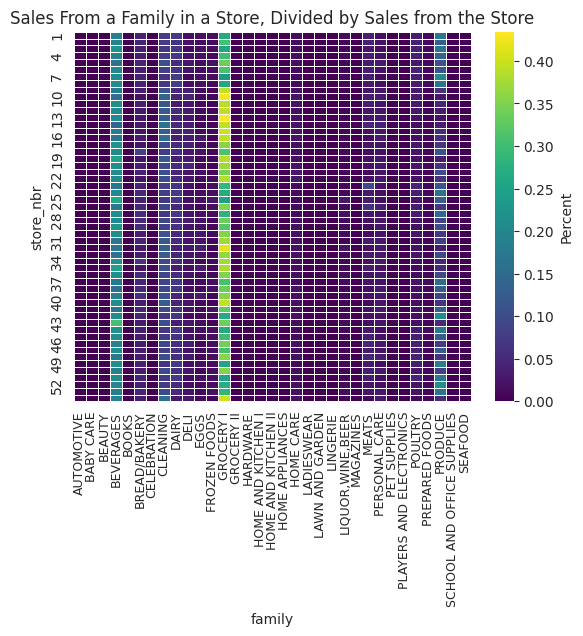

In [14]:
from copy import copy

grouped_sum = train_data.groupby(['store_nbr', 'family']).sum()
grouped_store_sum = train_data.groupby(['store_nbr']).sum()
grouped_family_distribution = copy(grouped_sum)
grouped_family_distribution['sales'] = grouped_sum['sales'] / grouped_store_sum['sales']

# Pivot the table
heatmap_data = grouped_family_distribution.pivot_table(index='store_nbr', columns='family', values='sales')

# Create a heatmap using seaborn
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", linewidths=.5, xticklabels=True, cbar_kws={'label': 'Percent'})
plt.title("Sales From a Family in a Store, Divided by Sales from the Store")
plt.xticks(fontsize=9)
plt.show()

<span style="font-size: 14pt; font-family: 'Circular';">

Both heat maps tell a simlar story; Grocery I is the clear leader in sales,with other popular product families inclduing Beverages, Produce, Cleaning, and Dairy, aswell as one or two additional families also being significant contributors. (comment on what the linear bands show). When constructing our first ML forecasting models, we focus our attension on forecasting sales in one of the highest selling areas in the heatmap, namely store 47's Grocery 1 product family.

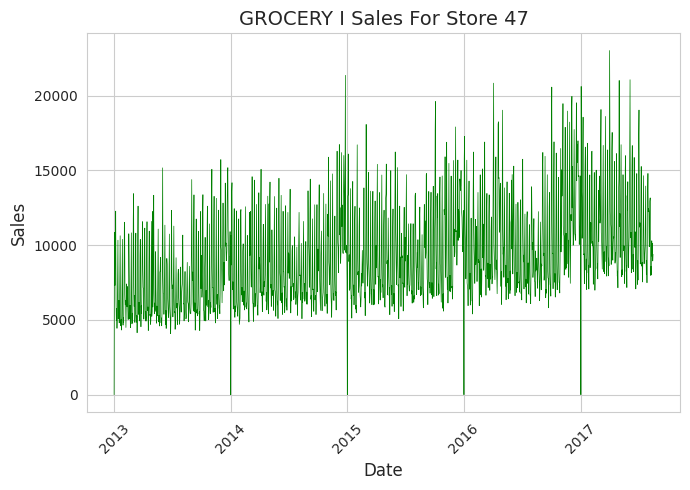

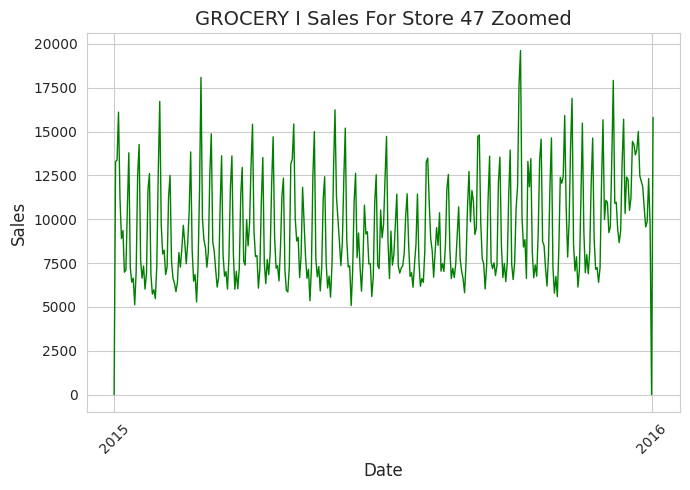

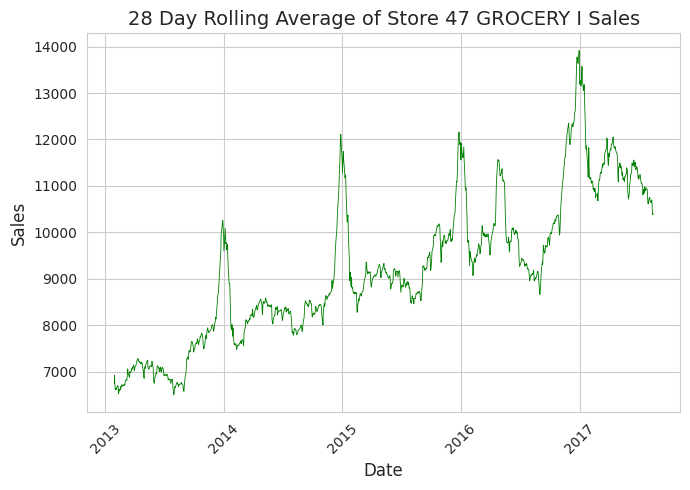

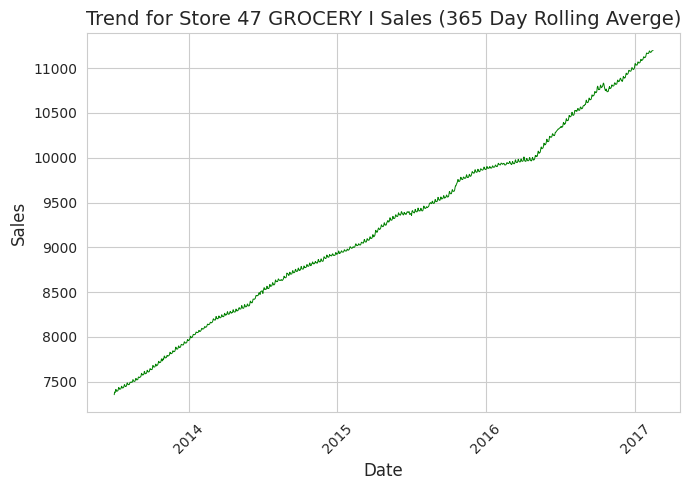

In [15]:
summary(train_data, 47,"GROCERY I")

<span style="font-size: 14pt; font-family: 'Circular';">

In the above data there is a strikingly consistent seasonal pattern, and a very linear trend. It therefore appears that this data set is the most structured out of the ones we have investigated so far. This means our ML models will likely predict future values succesfully in this case. 

(Mention earth quake here. That we will include the time periods related to earthquake as a feature)

## Building a Model Using Linear Regression  <a class="anchor"  id="chapter4"></a>

(Give very breif summary of linear regression here)

<span style="font-size: 14pt; font-family: 'Circular';">
   
### <span id = "adding-features-to-capture-patterns" style="color:#696969;font-size: 17pt;">Adding Features to Capture Patterns</span>

    
Now that we are more familiar with our data set, we are almost ready to train our first machine learning model to be used for forecasting future sales, which will be a linear regression model. 
    
First we must add features to our training set so that it contains information such as the day of the week and the month of the year which we found during the EDA to be important predictors of sales. Without adding these features we cannot expect a model such as linear regression to be able to learn how this information leads to changes in sales.
    
Now lets access store 47's grocery I data. 

In [16]:
store47_groceryI = cross_section(train_data, 47, "GROCERY I")

display(store47_groceryI)

,id,sales,onpromotion
date,,,
2013-01-01,1365,0.0,0
2013-01-02,3147,10867.0,0
2013-01-03,4929,7325.0,0
2013-01-04,6711,7317.0,0
2013-01-05,8493,10567.0,0
...,...,...,...
2017-08-11,2993343,10297.0,42
2017-08-12,2995125,9258.0,40
2017-08-13,2996907,10110.0,37


<span style="font-size: 14pt; font-family: 'Circular';">

First we add features that encode for the day of the weak and the month of the year, and display the modified data frame. 

In [17]:
store47_groceryI['day_of_week'] = store47_groceryI.index.day_name()
store47_groceryI['month_of_year'] = store47_groceryI.index.month_name()

display(store47_groceryI)

,id,sales,onpromotion,day_of_week,month_of_year
date,,,,,
2013-01-01,1365,0.0,0,Tuesday,January
2013-01-02,3147,10867.0,0,Wednesday,January
2013-01-03,4929,7325.0,0,Thursday,January
2013-01-04,6711,7317.0,0,Friday,January
2013-01-05,8493,10567.0,0,Saturday,January
...,...,...,...,...,...
2017-08-11,2993343,10297.0,42,Friday,August
2017-08-12,2995125,9258.0,40,Saturday,August
2017-08-13,2996907,10110.0,37,Sunday,August


<span style="font-size: 14pt; font-family: 'Circular';">

Notice two new columns have been added as expected. These columns contain categorical data, however since linear regression is only able to process numerical information we need to convert each category in each of these columns into a new "dummy" column, using pandas' get_dummies function. 

In [18]:
store47_groceryI = pd.get_dummies(store47_groceryI, columns = ['day_of_week', 'month_of_year'],dtype = int, prefix = "is")

pd.set_option('display.max_columns', 10)
display(store47_groceryI)

,id,sales,onpromotion,is_Friday,is_Monday,...,is_March,is_May,is_November,is_October,is_September
date,,,,,,,,,,,
2013-01-01,1365,0.0,0,0,0,...,0,0,0,0,0
2013-01-02,3147,10867.0,0,0,0,...,0,0,0,0,0
2013-01-03,4929,7325.0,0,0,0,...,0,0,0,0,0
2013-01-04,6711,7317.0,0,1,0,...,0,0,0,0,0
2013-01-05,8493,10567.0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2993343,10297.0,42,1,0,...,0,0,0,0,0
2017-08-12,2995125,9258.0,40,0,0,...,0,0,0,0,0
2017-08-13,2996907,10110.0,37,0,0,...,0,0,0,0,0


We are on the right track. Lets now add additional features which encode for some holiday and event information. Notice in the above data frame that there were no sales on 2013-01-01. This is because of New Years Day which is a national holiday in ecuador. We better add a feature which encodes for this information. 

In addition, other significant holidays and events include Christmas Day, May first Labor Day, and the earthquake on April 16 2016. In order to make it easier to add features for this information, we define the following functions. 

In [19]:
# accepts a series whose values represent dates. Returns a new series which has its values replaced by 0's and 1's depending on weather or not the date 
# values were new years day or not
def is_newyears(date_series):
    return ((date_series.dt.day == 1) & (date_series.dt.month == 1)).astype(int)

# works the sames as is_newyears, but adds 1's for days which are Christmas
def is_christmas(date_series):
    return ((date_series.dt.day >= 10) & (date_series.dt.month == 12)).astype(int)

# works the sames as is_newyears, but adds 1's for days which are May first.
def is_may_first(date_series):
    return ((date_series.dt.day == 1) & (date_series.dt.month == 5)).astype(int)

# accepts a series whose values represent dates. Returns a new series which has its values replaced by 0's and 1's depending on weather or not the date 
# values are close to the Earthquake on "04-16-2016".
def is_earthquake(date_series):
    day_of_earthquake = "04-16-2016"
    return ((date_series >= pd.to_datetime(day_of_earthquake)) & (date_series < pd.to_datetime("05-07-2016"))).astype(int)

In [20]:
# creating one hot features that account for holidays
store47_groceryI['is_christmas'] = is_christmas(pd.Series(store47_groceryI.index,index = store47_groceryI.index))
store47_groceryI["is_earthquake"] = is_earthquake(pd.Series(store47_groceryI.index,index = store47_groceryI.index))
store47_groceryI["is_newyears"] = is_newyears(pd.Series(store47_groceryI.index,index = store47_groceryI.index))
store47_groceryI["is_may_first"] = is_may_first(pd.Series(store47_groceryI.index,index = store47_groceryI.index))


pd.set_option('display.max_columns', 15)
display(store47_groceryI) 

,id,sales,onpromotion,is_Friday,is_Monday,is_Saturday,is_Sunday,...,is_November,is_October,is_September,is_christmas,is_earthquake,is_newyears,is_may_first
date,,,,,,,,,,,,,,,
2013-01-01,1365,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0
2013-01-02,3147,10867.0,0,0,0,0,0,...,0,0,0,0,0,0,0
2013-01-03,4929,7325.0,0,0,0,0,0,...,0,0,0,0,0,0,0
2013-01-04,6711,7317.0,0,1,0,0,0,...,0,0,0,0,0,0,0
2013-01-05,8493,10567.0,0,0,0,1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2993343,10297.0,42,1,0,0,0,...,0,0,0,0,0,0,0
2017-08-12,2995125,9258.0,40,0,0,1,0,...,0,0,0,0,0,0,0
2017-08-13,2996907,10110.0,37,0,0,0,1,...,0,0,0,0,0,0,0


One very important feature is missing from store47_groceryI. Right now we have enough information in this data frame to allow linear regression to learn how weekly, seasonal, and holidiay information can be used to predict store sales. This encodes for much of the occilatory behaviour found in the plot of store 47 grocery 1 sales which we plotted using the summary funciton earlier. However there is a key pattern present in these summary plots which as of now linear regression will not be able to capture from the store47_groceryI data frame. Do you know what this pattern is? 

Right now there is no information which is representing time by which linear regression can learn from. Of course the date index encodes for time, but linear regression does not view this as a column which it can learn from as it is the index, and in addition these dates are non-numerical. Therefore in the present state linear regression will not be able to project the linear trend when forcasting, and this is a huge disadvantage. 

To remedy this problem we include another feature in store47_groceryI which is "time". This column stores the number of days which have past since the first row in our data set namely 2013-01-01.

In [21]:
store47_groceryI["time"] = (store47_groceryI.index - pd.to_datetime("2013-01-01")).days

display(store47_groceryI)

,id,sales,onpromotion,is_Friday,is_Monday,is_Saturday,is_Sunday,...,is_October,is_September,is_christmas,is_earthquake,is_newyears,is_may_first,time
date,,,,,,,,,,,,,,,
2013-01-01,1365,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0
2013-01-02,3147,10867.0,0,0,0,0,0,...,0,0,0,0,0,0,1
2013-01-03,4929,7325.0,0,0,0,0,0,...,0,0,0,0,0,0,2
2013-01-04,6711,7317.0,0,1,0,0,0,...,0,0,0,0,0,0,3
2013-01-05,8493,10567.0,0,0,0,1,0,...,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2993343,10297.0,42,1,0,0,0,...,0,0,0,0,0,0,1683
2017-08-12,2995125,9258.0,40,0,0,1,0,...,0,0,0,0,0,0,1684
2017-08-13,2996907,10110.0,37,0,0,0,1,...,0,0,0,0,0,0,1685


<span style="font-size: 14pt; font-family: 'Circular';">
    
    
  

### <span id = "training-our-model" style="color:#696969;font-size: 17pt;">Training Our Model</span>


Now we are ready to split our data into train and validation sets, and then we will train our model. First we make sure to drop our target column namely, "sales" as we never want our target column to be in our training data. 

In [22]:


# our target 
y = store47_groceryI["sales"]
# dropping target from training data
X = store47_groceryI.drop(columns = ['sales'])

split_date = pd.to_datetime('2016-01-01')
X_train = X[:split_date]
X_val = X[split_date:]
y_train = y[:split_date]
y_val = y[split_date:]

The below code is all it takes to train our linear regression model:

In [23]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Now we can make our predictions using the model and store our results in two series y_fit (fitted values) and y_pred (our forcasted values). The method .predict returns an array which is why we created a series in the below code. 

In [24]:
# the values which our model has forecasted into the future.
y_pred = lr_model.predict(X_val)
y_pred = pd.Series(y_pred, index = y_val.index)
# we also store the sales values which our model has estimated over the dates corresponding to the training data.
y_fit = lr_model.predict(X_train)
y_fit = pd.Series(y_fit, index = y_train.index)

### <span id = "visualizing-and-testing-our-model" style="color:#696969;font-size: 17pt;">Visualizing and Testing Our Model</span>


One way to understand how accurate our forecast is, is to plot the two series genreated from our machine learning model above, along with our target series y. We will do this over and over agian in the future, so we decide to create a function which helps us with this, called forecast_summary.

(Add legend on below plot. Breifly describe rmsle)

In [25]:
from datetime import timedelta
import numpy as np

# a measure of the difference between two vectors/series y_true and y_pred. Stands for Root Mean Squared Logarithmic Error
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Length of y_true and y_pred must be the same."
    # Convert to numpy arrays to handle numerical operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    return rmsle

# accepts a series s and returns a new series with all of its negative values replaced by zeros. Used to avoid undefined values within the log of rmsle
def negative_to_zero(s):
    s = s.copy()
    s[s < 0] = 0
    return(s)

# Plots the series y and the forecasted and fitted values stored in the series y_fit and y_pred generated by a model. 
# Assumes there has been atleast six months of training data.
def forecast_summary(y,y_fit,y_pred, y_color,title):
    # Set the style
    sns.set_style("whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 7))
    # plot y
    sns.lineplot(data=y, color=y_color, linewidth=0.5, linestyle='-', label='Actual Values')
    # plot y_fit
    sns.lineplot(data=y_fit, color='blue', linewidth=0.5, linestyle='-',label='Fitted Values')
     # plot y_pred
    sns.lineplot(data=y_pred, color='turquoise', linewidth=0.5, linestyle='-',label='Forecasted Values')
    
    # Customize labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.title(title, fontsize=14)
    
    # Customize tick labels
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)
    
    # Set the major locator for x-axis ticks every year
    plt.gca().xaxis.set_major_locator(YearLocator())
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # create second plot
    plt.figure(figsize=(10, 7))

    start_date = y_fit.index.max()- timedelta(days=6*30)
    end_date = y_pred.index.min() + timedelta(days=375)
    
    sns.lineplot(data=y[start_date:end_date], color=y_color, linewidth=1.4, linestyle='-',label='Actual Values')
    sns.lineplot(data=y_fit[start_date:], color='blue', linewidth=0.8, linestyle='-',label='Fitted Values')
    sns.lineplot(data=y_pred[:end_date] , color='turquoise', linewidth=0.8, linestyle='-',label='Forecasted Values')
    
    # Customize labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.title(f'{title} Zoomed', fontsize=14)

    # Customize tick labels
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)
    
    # Set the major locator for x-axis ticks every year
    plt.gca().xaxis.set_major_locator(YearLocator())
    
    # Show the legend
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # calculating relevant errors:
    fitted_error = rmsle(y[:y_fit.index.max()],negative_to_zero(y_fit))
    forecasted_error = rmsle(y[y_pred.index.min():],negative_to_zero(y_pred))
    
    print("RMSLE for fitted values:", fitted_error)
    print("RMSLE for forecasted values:", forecasted_error)

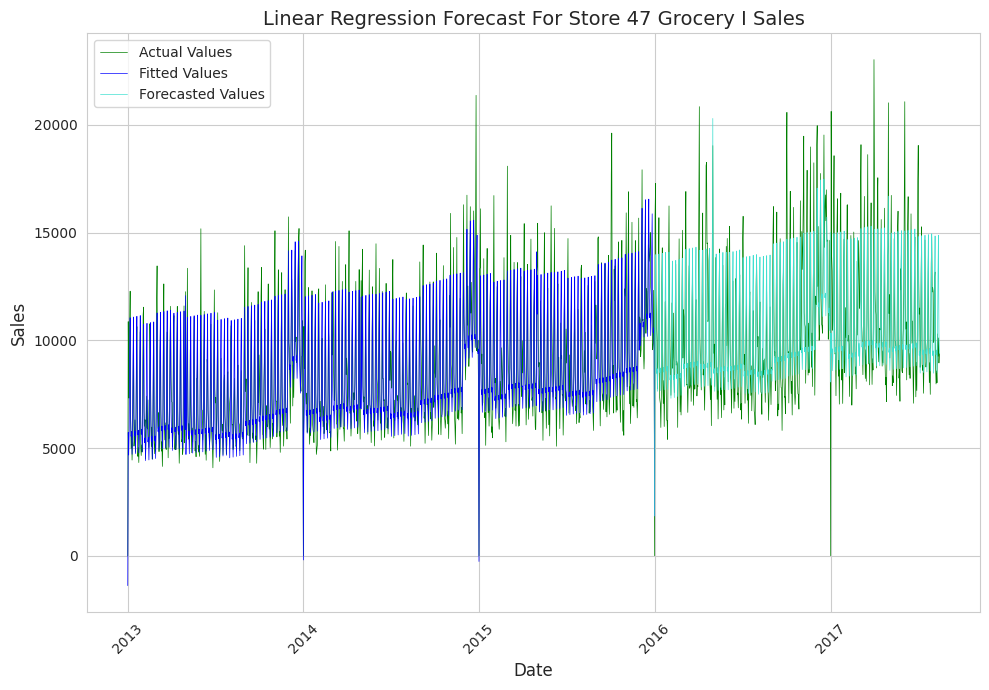

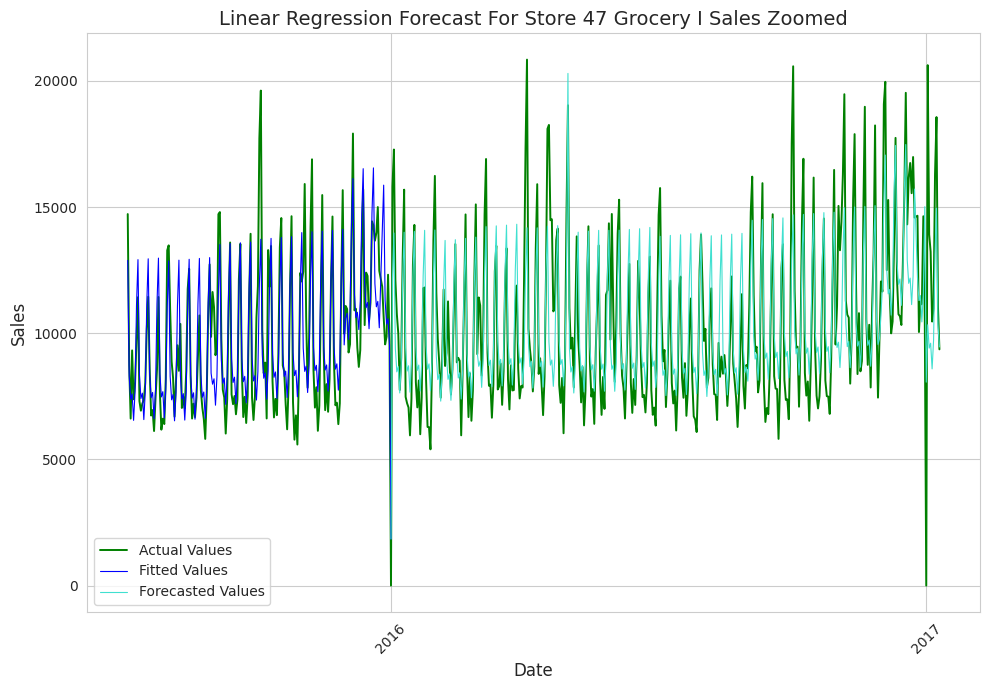

RMSLE for fitted values: 0.2738816700920969
RMSLE for forecasted values: 0.5092925580832622


In [26]:
forecast_summary(y,y_fit,y_pred, "green","Linear Regression Forecast For Store 47 Grocery I Sales")


### <span id = "what-linear-regression-canont-capture" style="color:#696969;font-size: 17pt;">What Linear Regression Cannot Capture</span>


Linear regression does quite a good job capturing the behaviour of store 47 Grocery 1 sales. Notice however, Jan 1st 2017 is not estimated well. This is because this date was a Sunday (the most popular day for shopping) which linear regression takes into consideration, despite it being a holiday. Idealy we would like our model to be able to use logic, and think in terms of decision statements; for example if its newyears day,than sales = 0. However linear regression is incapable of processing information in this way. This is one of the limitations of linear regression. 

(Foreshadow into how XGBoost remedys this issue, however explain that XGB can stuggle to capture linear trends. Then mention how in a future post we will discuss how to make a hybrid model combining the advanteges of XGB and linear regression)

## Conclusions <a class="anchor"  id="chapter5"></a>

## Next post XGB, lag features and hybrid modelling.......

The rest is rough and runs well in an earlier version of note book. Changed some variable names above which causes errors below. 

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from copy import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from collections import Counter
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from IPython.display import display

In [28]:
test_data = pd.read_csv(comp_dir / 'test.csv')
holidays = pd.read_csv(comp_dir / 'holidays_events.csv')

In [29]:
last_date = pd.to_datetime('2016-01-01')

X_gb = X.drop(columns=['time'])
X_train_gb = X_gb[:last_date - pd.Timedelta(days=1)]
X_val_gb = X_gb[last_date:]

new_params = {
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': 5,
}

# Train and apply Regressor
model_gb = XGBRegressor(**new_params)
model_gb.fit(X_train_gb, y_train)
y_fit_gb = model_gb.predict(X_train_gb)
y_pred_gb = model_gb.predict(X_val_gb)

y_fit_gb = pd.Series(y_fit_gb, index = y_train.index)
y_pred_gb = pd.Series(y_pred_gb, index = y_val.index)

plt.figure(figsize=(16, 8))
plt.plot(y["2015-08-01":],linestyle='-', color="green", linewidth=1)
plt.plot(y_fit_gb["2015-08-01":], linestyle='-', color="skyblue", linewidth=1)
plt.plot(y_pred_gb, linestyle='-', color="blue", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("LGBM Forecast")

# Adding x-axis ticks every year
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(YearLocator())
    
# Adding vertical lines for Jan 1st of each year
for year in range(2016, 2018):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='lightgrey', linestyle='--', linewidth=0.8)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(y,linestyle='-', color="green", linewidth=1)
plt.plot(y_fit_gb, linestyle='-', color="skyblue", linewidth=1)
plt.plot(y_pred_gb, linestyle='-', color="blue", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("LGBM Forecast")

# Adding x-axis ticks every year
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(YearLocator())
    
# Adding vertical lines for Jan 1st of each year
for year in range(2016, 2018):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='lightgrey', linestyle='--', linewidth=0.8)

plt.show()

print("Error for Fit:", mean_squared_error(y_fit_gb, y_train))
print("Error for Forecast:", mean_squared_error(y_pred_gb, y_val))

XGBoostError: [19:03:11] /workspace/src/data/data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (1 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x3588ca) [0x7e3f63cbd8ca]
  [bt] (1) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x389af7) [0x7e3f63ceeaf7]
  [bt] (2) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x38ab51) [0x7e3f63cefb51]
  [bt] (3) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xb0) [0x7e3f63ac33a0]
  [bt] (4) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7e3ff155ba4a]
  [bt] (5) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7e3ff155afea]
  [bt] (6) /opt/conda/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x7e3ff1573461]
  [bt] (7) /opt/conda/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x7e3ff15696eb]
  [bt] (8) /opt/conda/bin/python3.10(_PyObject_MakeTpCall+0x26b) [0x59e86a66497b]



Notice that XGBoost does a decent job at fitting the training data, but for the forecast its predictions lie much lower than the actual values. This is because it does not capture the upward trend that is captured by linear regression. In otherwards; XGBoost can interpolate this data succesfully, however it struggles with extrapolation in this case. If there was no upward trend the values of the feautes of the data would be relatively bounded over time, and so the feature values in the test data would be relatively similar to those in the training data.

Throughout the rest of this notebook we work with two approaches to remedy this issue. The first involves applying XGBoost to the residuals of the linear regression model, and then adding the forecasted residuals to the linear regression predictions, in order to get the predicted values for this hybrid approach. 

## XGB Applied to the Residuals of The Linear Regression Model <a class="anchor"  id="chapter4"></a>
 Observe that the residuals below lack a trend and seem to have a mean of 0 and constant variance over the train and test intervals. Thus the range of feature values in the test set will be similar to the range of feature values in the training set. XGBoost will likely be able to make more accurate predictions for these residuals in comparison to the original data. We also add additional features in order to enhance the performance of XGBoost, and to see which features may have an impact on grocery sales.

In [ ]:
r_lin = pd.concat([(y_train - y_fit),(y_val - y_pred)])

plt.figure(figsize=(16, 8))
plt.plot(r_lin,linestyle='-', color="green", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Residuals 
          From Linear Regression")

# Adding x-axis ticks every year
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(YearLocator())
    
# Adding vertical lines for Jan 1st of each year
for year in range(2013, 2018):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='lightgrey', linestyle='--', linewidth=0.8)

# Drawing a line to separate fitted residuals from forcasted residuals
plt.axvline(pd.to_datetime("2016-01-01"), color='blue', linestyle='--', linewidth=0.8)
# Adding a horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=0.8)

plt.show()



In [ ]:
holidays = pd.read_csv(comp_dir / 'holidays_events.csv')
holidays["date"] = pd.to_datetime(holidays["date"])
holidays = holidays.set_index("date")

hol = holidays[["type","locale"]]
#hol = clean_holidays(hol,remove_list)

# using max as an OR operator to handle cases where there is more than one holiday per day
hol = hol.groupby("date").max()

hol = pd.get_dummies(hol, prefix=['is', 'is'], dtype = int)
#hol_train = hol_dummies["2013-01-01":"2017-08-31"]


In [ ]:
# JUST ADD FEATURES TO ORIGINAL FEATURE SET. THIS IS CLEARER TO THE VEIWER I BELEIVE

train_data = pd.read_csv(comp_dir / 'train.csv')
train_data['date'] = pd.to_datetime(train_data['date']).sort_index()

# change to query
X_hybrid = train_data.loc[(train_data['store_nbr'] == 47) & (train_data['family'] == "GROCERY I")].copy()
X_hybrid.drop(columns = ["store_nbr","family","id"], inplace = True)
X_hybrid.set_index('date', inplace=True)
X_hybrid.drop(columns = ["sales"],inplace = True)

pd.set_option('display.max_columns', None)

print("r_lin:",r_lin)

# creating one hot features that account for holidays
X_hybrid['is_christmas'] = is_christmas(pd.Series(X_hybrid.index,index = X_hybrid.index))
X_hybrid["is_earthquake"] = is_earthquake(pd.Series(X_hybrid.index,index = X_hybrid.index))
X_hybrid["is_newyears"] = is_newyears(pd.Series(X_hybrid.index,index = X_hybrid.index))
X_hybrid["is_may_first"] = is_may_first(pd.Series(X_hybrid.index,index = X_hybrid.index))


# Creating dummy variables for the day of the week
X_hybrid['day_of_week'] = X_hybrid.index.day_name()
day_of_week_dummies = pd.get_dummies(X_hybrid['day_of_week'], prefix='is', dtype='int')
# Concatenate the dummy variables with the original DataFrame
X_hybrid = pd.concat([X_hybrid, day_of_week_dummies], axis=1)
# Drop the original 'day_of_week' column 
X_hybrid = X_hybrid.drop('day_of_week', axis=1)

# Creating dummy variables for the month of the year
X_hybrid['month_of_year'] = X_hybrid.index.month_name()
month_of_year_dummies = pd.get_dummies(X_hybrid['month_of_year'], prefix='is', dtype='int')
# Concatenate the dummy variables with the original DataFrame
X_hybrid= pd.concat([X_hybrid, month_of_year_dummies], axis=1)
# Drop the original 'day_of_week' column if needed
X_hybrid = X_hybrid.drop('month_of_year', axis=1)
    
X_hybrid["lag17"] = r_lin.shift(periods=17)
X_hybrid["lag18"] = r_lin.shift(periods=18)
X_hybrid["lag19"] = r_lin.shift(periods=19)
X_hybrid["lag20"] = r_lin.shift(periods=20)
X_hybrid["lag21"] = r_lin.shift(periods=21)
X_hybrid["lag23"] = r_lin.shift(periods=23)
X_hybrid["lag25"] = r_lin.shift(periods=25)
X_hybrid["lag27"] = r_lin.shift(periods=27)
X_hybrid["lag28"] = r_lin.shift(periods=28)
X_hybrid["lag29"] = r_lin.shift(periods=29)
X_hybrid["lag30"] = r_lin.shift(periods=30)
X_hybrid["lag31"] = r_lin.shift(periods=31)
X_hybrid["lag32"] = r_lin.shift(periods=32)

X_hybrid.fillna("blah", inplace = True)
# Merge the DataFrames based on their indices (dates)
X_hybrid = pd.merge(X_hybrid, hol, left_index=True, right_index=True, how='left')
# Fill NaN values with 0
X_hybrid = X_hybrid.fillna(int(0))
# turn "blah" values back to NA
X_hybrid.replace("blah", np.nan, inplace=True)

X_train_hybrid = X_hybrid[X_hybrid.index < last_date]
X_val_hybrid = X_hybrid[X_hybrid.index >= last_date]

print("X_train_hybrid", X_train_hybrid)

new_params = {
    'learning_rate': 0.01,
    'n_estimators': 500,
    'max_depth': 5,
    'subsample':0.5
}

params2 = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'min_child_weight': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'learning_rate': 0.02,
    'n_estimators': 500,
    'eval_metric': 'rmse'  # Use RMSE as the evaluation metric
}

r_train = r_lin[:last_date - pd.Timedelta(days=1)]
r_val = r_lin[last_date:]

# Train and apply Regressor
model_hybrid = XGBRegressor(**params2)
model_hybrid.fit(X_train_hybrid, r_train)

r_fit = model_hybrid.predict(X_train_hybrid)
r_pred = model_hybrid.predict(X_val_hybrid)

r_fit = pd.Series(r_fit, index = r_train.index)
r_pred = pd.Series(r_pred, index = r_val.index)

plt.figure(figsize=(16, 8))
plt.plot(r_lin["2015-08-01":],linestyle='-', color="green", linewidth=1)
plt.plot(r_fit["2015-08-01":], linestyle='-', color="skyblue", linewidth=1)
plt.plot(r_pred, linestyle='-', color="blue", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("LGBM Forecast")

# Adding x-axis ticks every year
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(YearLocator())
    
# Adding vertical lines for Jan 1st of each year
for year in range(2016, 2018):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='lightgrey', linestyle='--', linewidth=0.8)

plt.show()

plt.figure(figsize=(16, 8))
plt.plot(r_lin,linestyle='-', color="green", linewidth=1)
plt.plot(r_fit, linestyle='-', color="skyblue", linewidth=1)
plt.plot(r_pred, linestyle='-', color="blue", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("XGBoost Forecast of Residuals")

# Adding x-axis ticks every year
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(YearLocator())
    
# Adding vertical lines for Jan 1st of each year

for year in range(2016, 2018):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='lightgrey', linestyle='--', linewidth=0.8)

plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(r_lin, lags=40, ax=ax)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

print("list of features:",len(X_train_hybrid.columns))


In [ ]:
# up  date by adding residual model to linear regression.

#r_hybrid = pd.concat([(r_train - r_fit),(r_val - r_pred)])

print(mean_squared_error(r_pred, r_val))
print(np.std(r_val)**2)



In [ ]:
print("list of added features",X_hybrid.columns[:100])
print("list of added features",X_hybrid.columns[100:])

DESCRIBE THE BELOW ALGORITHM BY MAKING AN ANOLOGY TO DRAWING SECANTS IN THE GRAPH Y = X^2. The secants are simple and have slope 1 /(2n + 1). Perhaps use a table of values and reference the differences instead of drawing a parabola. This could be simpler. 

In [ ]:


# create feature engineering function which adds holiday and lag features 
def add_lag_holiday_features(d,h):
    data = d.copy()
    
    # creating one hot features that account for key holidays and events 
    data['is_christmas'] = is_christmas(pd.Series(data["date"]))
    data["is_earthquake"] = is_earthquake(pd.Series(data["date"]))
    data["is_newyears"] = is_newyears(pd.Series(data["date"]))
    data["is_may_first"] = is_may_first(pd.Series(data["date"]))
    
    data = pd.merge(data, h, left_on="date", right_index=True, how='left')
    data = data.fillna(int(0))
    
    # moved this ahead of the merge, before it was before the merge
    id_list = data.index.tolist()
    data.set_index('date', inplace=True)
    
    data['lag_sales_17'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=17)
    data['lag_sales_18'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=18)
    data['lag_sales_19'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=19)
    data['lag_sales_20'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=20)
    data['lag_sales_21'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=21)
    data['lag_sales_23'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=23)
    data['lag_sales_25'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=25)
    data['lag_sales_27'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=27)
    data['lag_sales_28'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=28)
    data['lag_sales_29'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=29)
    data['lag_sales_30'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=30)
    data['lag_sales_31'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=31)
    data['lag_sales_32'] = data.groupby(["store_nbr", "family"])['sales'].shift(periods=32)
    
    data.reset_index(inplace = True)
    data.index = id_list
    
    return(data)
    
# to_delta function. Merges data with another dataframe back shifted four weeks. This doubles the amount of rows approximately. Also this function replaces the two target columns 
# with the difference between them. 
# rename def add_delta_features. This function adds the useful features associated with the 28-day shift. These added features are necessary when predicting the values of the transformed delta data . 
def to_delta(d):
    
    data = d.copy()
    
    ids = data.index
    data.set_index('date', inplace=True)
    
    prev_data = data.groupby(["store_nbr", "family"]).shift(periods=21).copy()
    
    prev_data.reset_index(inplace = True)
    prev_data.index = ids
    data.reset_index(inplace = True)
    data.index = ids
    prev_data.drop(columns = ['date'], inplace = True)  
    
    # Rename columns with prefix "prev"
    prev_data = prev_data.add_prefix('prev_')
    combined_data = data.join(prev_data)

    # create delta_sales column
    #combined_data["delta_sales"] = combined_data["sales"] - combined_data["prev_sales"]
    
    # drop other two sales columns
    combined_data.drop(columns = ["sales","prev_sales"], inplace = True)
    
    return(combined_data)


# rename add_date_features
def extract_date_features(d):
    data = d.copy()
    data['day_of_week'] = data["date"].dt.day_name()
    data['month_of_year'] = data["date"].dt.month_name()
    return(data)

# add features that do not need to have duplicates
def add_remaining_features(d):
    data = d.copy()
    
    data['new'] = (data["date"].dt.year >= 2015).astype(int)
    # Creating dummy variables for the day of the week
    data['day_of_week'] = data["date"].dt.day_name()
    
    # Creating dummy variables for the month of the year
    data['month_of_year'] = data["date"].dt.month_name()
    
    data = pd.get_dummies(data, columns = ['day_of_week', 'month_of_year','family','store_nbr'],dtype = int, prefix = "is")
    data['year'] = data["date"].dt.year
    
    return(data)

#X_delta = add_lag_holiday_features(X_delta, hol)
#print("num columns before transformation",len(X_delta.columns))

#X_delta = to_delta(X_delta)
#print("num columns after transformation",len(X_delta.columns))

#X_delta = add_remaining_features(X_delta)
#print("num columns after second transformation",len(X_delta.columns))

#print("X_delta:",X_delta.tail())



# run model via pipeline in grocery 1 store 47 data. 

# make sure to make negative values zero 

# 30 day rolling average of error for each of 4 models. 

# when submitting experiement with a year feature and a first half / second half feature. 


Linear Regression ANOLOGY. SECANT ANALOGY.

In [ ]:
# returns the delta_sales given a data frame with a sales column, and the three columns, store_nbr, family, and date which uniquely identify each row. Drops all rows before date. This ensures the target series is the same length as the train data, which is truncated do to the NA values resulting from the lag shift being removed
def extract_delta_sales(d, date):
    data = d.copy()
    data["prev_sales"] = data.groupby(["store_nbr", "family"])["sales"].shift(periods=21).copy()
    data["delta_sales"] = data["sales"] - data["prev_sales"]
    # ensure that there are no na values other than the first 28, or else the target data won't be parallel with the training features. This should throw an error though.
    data = data[data["date"] >= date] 
    return(data.dropna()["delta_sales"])

# turns a series of forecasted delta sales into a forcasted series of sales. This is done by adding the rows of delta_sales to the corresponding 
# rows in prev_sales. prev_sales is the target extracted from training data. test_data_info, train_data_info must be included as they contain information 
# regarding how the ids are associated with the date, family and store_nbr values. These data frames should have only these three columns. train_data_info has a "sales" column aswell.

# create a new input variable which accounts for a variable target series essnentially replacing merge["sales"] . Or no?  
def delta_sales_to_sales(forcasted_delta_sales, train_data_info, test_data_info):
    train_data_info = train_data_info.copy()
    test_data_info = test_data_info.copy()
    
    train_data_info["date"] = train_data_info["date"] + pd.Timedelta(days=21)
    test_data_info["forcasted_delta_sales"] = forcasted_delta_sales 
    
    merge = pd.merge(test_data_info, train_data_info, on=['family','store_nbr','date'], how='left')
    assert(len(test_data_info) == len(merge))
    merge.set_index(test_data_info.index,inplace = True)
    
    test_data_info["prev_sales"] = merge["sales"]   
    forcasted_sales = test_data_info["prev_sales"] + test_data_info["forcasted_delta_sales"]
    
    return(forcasted_sales)

# requies "sales" column in train_data_info and test_data_info. Assumes first variable is a series.
def delta_sales_to_sales2(forcasted_delta_sales, train_data_info, test_data_info):
    train_data_info = train_data_info.copy()
    test_data_info = test_data_info.copy()
    
    assert(pd.isna(forcasted_delta_sales).any() == False)
    
    data_info = pd.concat([train_data_info, test_data_info ])
    data_info2 = data_info.copy()
    data_info2["forcasted_delta_sales"] = forcasted_delta_sales
    data_info2.drop(columns = ["sales"], inplace = True)
    
    data_info["date"] = data_info["date"] + pd.Timedelta(days=21)
    
    merge = pd.merge(data_info2, data_info, on=['family','store_nbr','date'], how='left')
    
    # stoped here. I beleive the above line will create two sales columns. One for shifted sales, and the other for not shifted. 
    # add shifted sales to forcasted delta sales in next lines. 
    
    #assert(len(test_data_info) == len(merge))
    merge.set_index(data_info2.index,inplace = True)
    merge.dropna(inplace = True)
    
    return(merge["forcasted_delta_sales"] + merge["sales"])

# concatonates test_data with recent values in train data, to allow for lag values for the sales column to be generated in the 
# add_lag_holiday_features stage of the pipeline. Concatenates all rows from train_data which occur on or after date, to test data.
def extend_test_data(test_data, train_data, date):
    relevant_rows = train_data[train_data["date"] >= date]
    stacked_df = pd.concat([relevant_rows,test_data], axis=0)
    return(stacked_df)

def add_missing_columns(d, col):
    data = d.copy()
    missing_columns = set(col) - set(data.columns)
    for c in missing_columns:
        data[c] = 0
    return(data)

# impute missing rows to assist with adding lag features. Avoids NA values being generated when adding lag features, which when dropped later in a pipeline cause train and target sets to be misaligned
def impute_missing_days(d, largest_index):
    data = d.copy()
    
    family_list = data['family'].unique().tolist()
    store_nbr_list = data['store_nbr'].unique().tolist()
    
    data['month_of_year'] = data["date"].dt.month_name()
    data['day_of_week'] = data["date"].dt.day_name()
    grouped_data = data.groupby(["store_nbr", "family","month_of_year","day_of_week"]).mean()
    data = data.drop(columns = ['month_of_year', 'day_of_week'])
    
    possible_days = pd.date_range(start=data["date"].min(), end=data["date"].max()).tolist()
    included_days = data["date"].tolist()
    
    column_list = ["date", "family",'onpromotion','sales',"store_nbr"]
    # Create an empty DataFrame
    extra_rows = pd.DataFrame(columns=column_list)

    i = largest_index + 1
    for date in (set(possible_days) - set(included_days)):
        for store_nbr in store_nbr_list:
            for family in family_list:
        
                month = date.month_name()
                day = date.day_name()
                
                onpromotion_est = grouped_data.loc[(store_nbr, family, month, day), 'onpromotion']
                sales_est = grouped_data.loc[(store_nbr, family, month, day), 'sales']
                
                new_row = {'date': date,"family":family,"onpromotion":onpromotion_est,"sales": sales_est, 'store_nbr': store_nbr }

                # Append the new row with the chosen index and name
                extra_rows.loc[i] = new_row
                i = i + 1
    data = pd.concat([data,extra_rows])
    return(data)
    
    
    
        

In [ ]:
y_diffed = y - y.shift(periods = 28)

plt.figure(figsize=(16, 8))
plt.plot(y_diffed, color="green", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.axhline(y=0, color='black', linewidth=0.8)
plt.title("Grovery I Sales for Store 47 Diffed")
plt.show()

rolling_avg = y_diffed.rolling(window=28).mean()
plt.figure(figsize=(16, 8))
plt.plot(rolling_avg, color="green", linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.axhline(y=0, color='black', linewidth=0.8)
plt.title("Rolling average Grovery I Sales for Store 47 Diffed")
plt.show()




In [ ]:
def my_drop(df):
    return(df.drop(columns=['date']))

def DataFramePrinter(df):
    print("my new print","\n",set(X_test.index) - set(df.index))
    if 1947309 in df.index.tolist():
        print("is it null???", df.loc[1947309].isnull().any())
        print("the whole row to see where the NA is",df.loc[1947309])
        
    return(df)

def negative_to_zero(s):
    s = s.copy()
    s[s < 0] = 0
    return(s)

def remove_added_rows(data,index):
    return(data[data.index <= index])

def transform_target(y):
    #result = np.cbrt(y)
    #result = np.log(y + 100000)
    #rint(y.max())
    #result = y
    result = np.sign(y) * np.abs(y) ** (1.0/2.0)
    return(result)

def inverse_transform_target(y):
    result = np.sign(y) * np.abs(y)**2.0
    #result = y
    #result = np.exp(y)- 100000
    return(result)

In [ ]:
# a list of columns that may or may not be present in the data after the stages in the pipeline.
# To ensure consistency between the processing of the training and test data we ensure that if one of these columns is not present, then in the pipeline a row of zeros is added with the appropriate name. 
# This will allow us to call .predict 
# import data. Index the data. 
train_data = pd.read_csv(comp_dir / 'train.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

X_train = train_data.loc[(train_data['store_nbr'] == 47) & (train_data['family'] == "GROCERY I")].copy()
#X_train = train_data.copy()
X_train.set_index("id", inplace = True)

# use the delta_train_and_test() function to do the following computations 

columns_to_impute = ['is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday', 'is_Wednesday','is_April', 'is_August', 'is_December', 'is_February', 'is_January', 'is_July', 'is_June', 'is_March', 'is_May', 'is_November', 'is_October', 'is_September']

largest_lag = 32
delta = 21
required_train_min_date = X_train["date"].min() + pd.Timedelta(days = largest_lag + delta) # may need to change if train and test data overlap
y_train = extract_delta_sales(X_train, required_train_min_date) # only include necessesary columns for speed?
#X_train.drop(columns = ["sales"])

test_data['date'] = pd.to_datetime(test_data['date'])
X_test = test_data.loc[(test_data['store_nbr'] == 47) & (test_data['family'] == "GROCERY I")].copy()
#X_test = test_data.copy()
X_test.set_index("id", inplace = True)

original_test_min_date = test_data['date'].min()
ext_test_min_date = original_test_min_date - pd.Timedelta(days = largest_lag + delta) 
X_test_ext = extend_test_data(X_test, X_train, ext_test_min_date)

largest_index = X_train.index.max()

params = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.08, # Initial learning rate
    'n_estimators': 1000,  # Number of boosting rounds
    'max_depth': 8,  # Maximum tree depth
    'subsample': 1,  # Subsample ratio of the training instances
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}


# Define the pipeline
delta_pipeline = Pipeline([
    # should I add global largest_index here? 
    
    # remove transformer names? 
    
    #Add lag and holiday features
    ("impute_missing_days", FunctionTransformer(impute_missing_days, kw_args={'largest_index': largest_index})),
    
    #("print_dataframe1", FunctionTransformer(DataFramePrinter)),
    
    ('add_lag_holiday_features', FunctionTransformer(add_lag_holiday_features, kw_args={'h': hol})),
    
    # Transform to delta
    ('to_delta', FunctionTransformer(to_delta)),
    
    # Extract date features
    ('extract_date_features', FunctionTransformer(extract_date_features)),
    
    # Add remaining features
    ('add_remaining_features', FunctionTransformer(add_remaining_features)),
    
    #("print_dataframe2", FunctionTransformer(DataFramePrinter)),
    
    # some lag values might be NA in the middle of the data this might need to be modified in order to make the two inputs in the .fit line parellel
    # this also trims the extra rows added in extend_test_data. Perhaps add a different function which trims based on date for clarity
    ('dropna', FunctionTransformer(lambda df: df.dropna())),
    
    # Drop the 'date' column
    
    ('imputer', FunctionTransformer(add_missing_columns, kw_args={'col': columns_to_impute})),
    
    ("sort_columns",FunctionTransformer(lambda df: df.sort_index(axis=1))),
    
    ('drop_date', FunctionTransformer(lambda df:df.drop(columns=['date']))),
    
    #("print_dataframe3", FunctionTransformer(DataFramePrinter)),
    
    ("remove_added_rows", FunctionTransformer(remove_added_rows, kw_args={'index': largest_index})),
    
    # Model
    ('model', XGBRegressor(**params))  # Model without specifying hyperparameters
    
    # Add custom step to add series to the regressor output
    #('add_series_to_regressor_output', FunctionTransformer(add_series_to_regressor_output, kw_args={'additional_series': additional_series})),
])

# Fit the pipeline to your data
#print(X_train.columns)
delta_pipeline.fit(X_train, transform_target(y_train))

# Once the pipeline is fitted, you can use it to make predictions

# Update the pipeline with the new value of largest_index
delta_pipeline.named_steps['impute_missing_days'].kw_args['largest_index'] = X_test_ext.index.max()
delta_pipeline.named_steps["remove_added_rows"].kw_args['index'] = X_test_ext.index.max()

delta_predictions = inverse_transform_target(delta_pipeline.predict(X_test_ext))

delta_predictions_series = pd.Series(delta_predictions, index = X_test.index)

sales_predictions = delta_sales_to_sales(delta_predictions_series, X_train[["family","store_nbr","date","sales"]],X_test[["family","store_nbr","date"]])

print("sales_predictions",sales_predictions)




# APPLY FORWARD SHIFT TO SALES AND THEN ADD IT INPIPELINE. Make forward shift function



In [ ]:


final_predictions = negative_to_zero(sales_predictions)
print("final_predictions",final_predictions)

submission_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv", index_col='id')
submission_df["sales"] = final_predictions

print(submission_df)

submission_df.to_csv('submission.csv')
print("Your submission was successfully saved!")


In [ ]:
# COMPARE SCORE WITH BASELINE WHICH IS SHIFTING BY A MONTH 
# COMPARE SCORE WITH BASELINE WHICH IS SHIFTING BY THREE WEEKS
# OPTOMIZE HYPERPARAMETERS FOR GROCERY STORE 47 DATA, try on whole data set
# COMPARE SCORE WITH BASELINE WHICH IS SHIFTING BY A MONTH 

# First Build a function which chooses data, and three dates, the first two of which describe the training data to extract from the
# data, the second two of which describe the testing interval from data. Also include a model / pipeline as a parameter.
# The function should train the model on the training subset of data, and then test and evaluate it's error using the required logarthimic function.

# Build another function using the previous function, which accepts a family and store_nbr as variables, and three dates, and calls the previous function
# on the associated dates and data, while also printing relavant plots including fitted and forcasted data. Perhaps also include Params as a parameter. 


In [ ]:
def rmsle(y_true, y_pred):
    """
    Compute Root Mean Squared Logarithmic Error (RMSLE) between two arrays.
    
    Parameters:
    y_true : array-like
        Array containing the true target values.
    y_pred : array-like
        Array containing the predicted target values.

    Returns:
    float
        RMSLE value.
    """
    assert len(y_true) == len(y_pred), "Length of y_true and y_pred must be the same."
    
    # Convert to numpy arrays to handle numerical operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    
    return rmsle


# Custom RMSLE objective function
def rmsle_objective(preds, labels):
    preds = np.maximum(preds, 0)  # Ensure predictions are non-negative
    grad = (np.log1p(preds) - np.log1p(labels)) / (preds + 1)  # Compute gradient
    hess = ((1 / (preds + 1)) - (np.log1p(preds) - np.log1p(labels)) / ((preds + 1) ** 2))  # Compute Hessian
    return grad, hess

In [ ]:
# id must be the index of data. The date column, as well as d1,d2,d3 must be of type datetime. Expects X_train is a suffciently long time period to handle required lag values.
# we can use this function to shorten the previous code. 
# assert d1 == X_train["date"].iloc[0]. If error, choose different date. 
# also incldude assert statement for beginning of X_test and d2 - shift (shift = 28 + maxlag)



def delta_train_and_test(delta_pipeline,data,d1,d2,d3, params):
    
    #global X_test
    
    X_train = data[(data["date"] >= d1) & (data["date"] <= d2)]
    delta_pipeline.named_steps['impute_missing_days'].kw_args['largest_index'] = X_train.index.max()
    delta_pipeline.named_steps["remove_added_rows"].kw_args['index'] = X_train.index.max()
    
    X_test = data[(data["date"] > d2) & (data["date"] <= d3)]
    
    required_train_min_date = X_train["date"].min() + pd.Timedelta(days = largest_lag + delta) # may need to change if train and test data overlap
    y_train = extract_delta_sales(X_train, required_train_min_date)
    
    original_test_min_date = X_test['date'].min()
    ext_test_min_date = original_test_min_date - pd.Timedelta(days = largest_lag + delta + 1) 
    X_test_ext = extend_test_data(X_test, X_train, ext_test_min_date)
    
    # Fit the pipeline to your data
    delta_pipeline.named_steps['model'].set_params(**params)
    delta_pipeline.fit(X_train, transform_target(y_train))

    # Once the pipeline is fitted, you can use it to make predictions
    delta_pipeline.named_steps['impute_missing_days'].kw_args['largest_index'] = X_test.index.max()
    delta_pipeline.named_steps["remove_added_rows"].kw_args['index'] = X_test.index.max()
    
    delta_predictions = inverse_transform_target(delta_pipeline.predict(X_test_ext))
    
    delta_predictions_series = pd.Series(delta_predictions, index = X_test.index)
    
    y_test = X_test["sales"]
    
    # test the effect of the following two lines 
    X_train = impute_missing_days(X_train, X_train.index.max())
    X_test = impute_missing_days(X_test, X_test.index.max())
    
    # include X_test[["sales"]]. Fix delta_sales_to_sales, to concat X_train["sales"] with X_test["sales"] vertically before creating new column of date shifted sales. Make the column "prev_sales" into this concatenated column. This should solve the error involving the NA values I beleive. 
    sales_predictions = delta_sales_to_sales2(delta_predictions_series, X_train[["family","store_nbr","date","sales"]],X_test[["family","store_nbr","date","sales"]])
    final_predictions = negative_to_zero(sales_predictions)
    
    
    assert(pd.isna(X_test["sales"]).any() == False)
    
    print("rmsle:", rmsle(y_test, final_predictions))
    #print("final_predictions", final_predictions)
    #print("y_test",y_test)

Produce a table comparing the three approaches on the Grovery 1 near the end before submitting predictions.

In [ ]:
# The off by one error occurs in pd.Series(delta_predictions, index = X_test.index), since delta_predictions has a length of 591 but index has a length of 592. 
# I beleive this is due to the line ('dropna', FunctionTransformer(lambda df: df.dropna())), and the lag features in add_lag_holiday_features. This is likely due to there being missing days in the data
# so the groupby/shift statement in add_lag_holiday_features, will generate NA rows which are then droped. Or perhaps this is being caused by something else. There would have to be a missing date within 60 days from Jan 2016 I beleive. 
# I could just impute these rows manually perhaps. Or should I impute inside / or outside of pipeline? I would have to impute the whole row I beleive. 

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

train_data = pd.read_csv(comp_dir / 'train.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

X_train = train_data.loc[(train_data['store_nbr'] == 47) & (train_data['family'] == "GROCERY I")].copy()
#X_train = train_data.loc[(train_data['store_nbr'].isin([3,16,19,40,43,47]))].copy()
#X_train = train_data.copy()
X_train.set_index("id", inplace = True)

data = X_train 

params1 = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.1,  # Initial learning rate
    'n_estimators': 100,  # Number of boosting rounds
    'max_depth': 3,  # Maximum tree depth
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}

params2 = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.1,  # Initial learning rate
    'n_estimators': 100,  # Number of boosting rounds
    'max_depth': 6,  # Maximum tree depth
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}

params3 = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.1,  # Initial learning rate
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum tree depth
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}

params4 = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.1,  # Initial learning rate
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum tree depth
    'subsample': 0.7,  # Subsample ratio of the training instances
    'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}

params5 = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.03,  # Initial learning rate
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum tree depth
    'subsample': 0.7,  # Subsample ratio of the training instances
    'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}

#delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params1)
#delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params2)
#delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params3)
#delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params4)
#delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params5)

Produce bar chart comparing the three models and there most important features. 

Produce average error over time for each? one month average.

Ask Chat GPT what are some useful plots when visualizing store sales. 




We create pipeline below

In [ ]:
delta_pipeline = Pipeline([
    # should I add global largest_index here? 
    
    # remove transformer names? 
    
    #Add lag and holiday features
    ("impute_missing_days", FunctionTransformer(impute_missing_days, kw_args={'largest_index': largest_index})),
    
    #("print_dataframe1", FunctionTransformer(DataFramePrinter)),
    
    ('add_lag_holiday_features', FunctionTransformer(add_lag_holiday_features, kw_args={'h': hol})),
    
    # Transform to delta
    ('to_delta', FunctionTransformer(to_delta)),
    
    # Extract date features
    ('extract_date_features', FunctionTransformer(extract_date_features)),
    
    # Add remaining features
    ('add_remaining_features', FunctionTransformer(add_remaining_features)),
    
    #("print_dataframe2", FunctionTransformer(DataFramePrinter)),
    
    # some lag values might be NA in the middle of the data this might need to be modified in order to make the two inputs in the .fit line parellel
    # this also trims the extra rows added in extend_test_data. Perhaps add a different function which trims based on date for clarity
    ('dropna', FunctionTransformer(lambda df: df.dropna())),
    
    # Drop the 'date' column
    
    ('imputer', FunctionTransformer(add_missing_columns, kw_args={'col': columns_to_impute})),
    
    ("sort_columns",FunctionTransformer(lambda df: df.sort_index(axis=1))),
    
    ('drop_date', FunctionTransformer(lambda df:df.drop(columns=['date']))),
    
    #("print_dataframe3", FunctionTransformer(DataFramePrinter)),
    
    ("remove_added_rows", FunctionTransformer(remove_added_rows, kw_args={'index': largest_index})),
    
    # Model
    ('model', XGBRegressor(**params))  # Model without specifying hyperparameters
    
    # Add custom step to add series to the regressor output
    #('add_series_to_regressor_output', FunctionTransformer(add_series_to_regressor_output, kw_args={'additional_series': additional_series})),
])

In [ ]:
params = {
    'objective': 'reg:squarederror',  # Set to 'reg:squarederror' for regression
    'learning_rate': 0.08, # Initial learning rate
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 8,  # Maximum tree depth
    'subsample': 1,  # Subsample ratio of the training instances
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 1,  # L2 regularization term on weights
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'seed': 42  # Random seed
}
delta_train_and_test(delta_pipeline,data, pd.to_datetime("2013-01-01"),pd.to_datetime("2015-12-31"),X_train["date"].max(),params)

# EXTRACT DELTA SALES MIGHT BE CAUSING THE ERROR 